On the road towards advancing python programming it's inevitable to learn how cpython interperter works and extend interpreter's functionality through python C api. However, the biggest difficulty is to know where and how to start especially when interpreter crashes. The online courses, [CPython Internals](http://pgbovine.net/cpython-internals.htm), taught by Philip Guo, gave brief background of computational theory behind the interpreter as a start to bridge what has been in practice.   
   
However, this course is taught with python 2.7. Some pieces are missing or not clarified in this mini-series lecture. Firstly, python 3.x diverges greatly from python 2.7 not only the python syntax itself but also the corresponding c api. Some materials of this course is slightly inapplicable to latest python version. Secondly, this series simply touches the surface of python c api and doesn't have sufficient time to dig deeper. I would like to fill up the gap and hopefully would gain some feedbacks from real cpython experts.  

<!-- TEASER_END -->

For most interpreter languages, they are built on top of other compiled language, mostly C. The general mechanism is the interpreter will parse the source code, construct a syntax tree, turn the source code into a series of byte code instructions (opcode) and rely on the low level language to execute the byte code instructions. It's like executing code on a "process virtual machine" without dealing with underlying hardware details but the interpreter, an executable process itself. Using "process virtual machine" is to distinguish "system virtual machine" widely used as guest OS. The interpreter will provide a set of opcode specs which is similar to the instructions in assembly. The process virtual machine model will then fetch, decode and execute instructions as a real CPU does to handle machine instructions. The implementation of process virtual machine. There are general two major implementations for process virtual machine: stack-based and register-based. One can refer [this link](https://markfaction.wordpress.com/2012/07/15/stack-based-vs-register-based-virtual-machine-architecture-and-the-dalvik-vm/) for further explanation. Basically stack-based virtual machine is using a in-memory stack to store the operands and results of execution. By doing so, bypass storing the address of operands but simply refering the pointer to the top of stack and pop. For example, python uses a value stack to execute the opcodes and push the result onto the top of stack. 

To illustrate how python intepreter works as a stack machine, we will need python built-in module **"dis"** to disassemble the byte codes and map the bytes to human readable instructions. Before using **"dis"**, we will need to compile the source into byte code. Following is a simple example:

In [25]:
import dis
code = """
x = 10
y = 11
print(x + y)
"""

co_obj = compile(code, 'current.py', 'exec')
dis.dis(co_obj)

import sys
stack_size = sys.getsizeof(co_obj.co_stacksize)
print()
print("Total stack size %d" % stack_size)

  2           0 LOAD_CONST               0 (10)
              3 STORE_NAME               0 (x)

  3           6 LOAD_CONST               1 (11)
              9 STORE_NAME               1 (y)

  4          12 LOAD_NAME                2 (print)
             15 LOAD_NAME                0 (x)
             18 LOAD_NAME                1 (y)
             21 BINARY_ADD
             22 CALL_FUNCTION            1 (1 positional, 0 keyword pair)
             25 POP_TOP
             26 LOAD_CONST               2 (None)
             29 RETURN_VALUE

Total stack size 3


**compile** function takes three arguments: the first is the source code in string which could either open a file and read in the python source or just give a raw string as the example. The second is a "faking" source code file name which does nothing important but logging for errors. Third argument is the mode to specify the kind of source. The possible values are **'exec'** for multiple statements and **eval** and **single** for single statement. Specifying **'exec'** will ensure the source code is compiled and dynamically executable.  

After you have compiled source code into byte code preresented as python code object, you can pass along into dis.dis functioni to disassemble. Other possible format other than code object can be also used, such as a function object or arbitrary python objects.

The **dis** module actually take the python object and call in the following functions to parse the byte code. It's a lightweight interpreter simulator without actually executing the code logics of opcode. I also attach the call graph generated via [pycallgraph](http://pycallgraph.slowchop.com/en/master/) which will give you an overview how dis.dis code is organized and prevent you from losing the code labyrinth while tracing. 

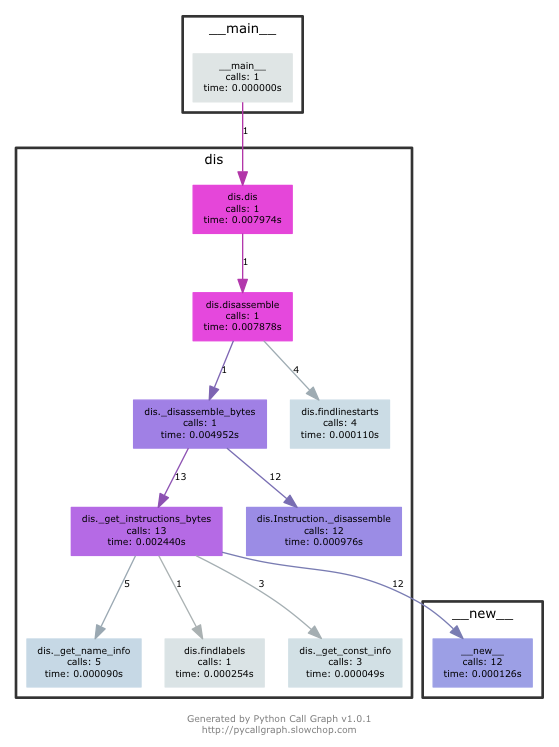

In [22]:
#ignore
from pycallgraph import PyCallGraph
from pycallgraph.output import GraphvizOutput
from pycallgraph import Config, GlobbingFilter
from contextlib import redirect_stdout

config = Config()
config.trace_filter = GlobbingFilter(exclude=[
    'pycallgraph.*',
    'threading.*',
    'contextlib.*',
    'redirect_stdout',
    '*.secret_function',
])

graphviz = GraphvizOutput(output_file='filter_exclude.png')
with PyCallGraph(output=graphviz, config=config):
  with redirect_stdout(None):
    dis.dis(co_obj)

from IPython.display import Image
Image(filename='filter_exclude.png', width=600, height=600)

The output of dis (despite header is absent) is:  
- source code line number (*dis.findlinestarts* in pycallgraph figure)
- labels (not shown in this example) includes current instruction **'&gt;'** and jump_target **'&gt;&gt;'** (*dis._findlabels* in pycallgraph figure)
- instruction offset or the position of the first byte of opcode in compiled byte source (*dis.Instruction_disassemble* in pycallgraph figure)
- the human readable name of opcode (*dis._get_name_info* in pycallgraph figure)
- the column used for arguments (*dis._get_const_info* in pycallgraph figure)
- the string expressions of arguments

For the opcode name, they are actually enum-like number in the C header. You can check out the corresponding integer number in Include/opcode.h. A simple rule to guess what these opcodes do without looking up references is speculating from the readable name. If the opcode name starts with **LOAD_XXX**, the functionality of this opcode is to lookup the local variable load from local variables and push the variable onto the stack; On the other hand, if the opcode name starts with **STORE_XXX**, the functionality of this opcode is to pop variable on the top of stack. But what a opcode actually does, one should look up the reference and also trace the C code to verify what reference said. 

For the offset of opcode, you can compute the size of an opcode by taking difference of two consecute opcodes offsets. For example, BINARY_ADD is an opcode of one byte size since it takes its two operands directly from the top of stack. And we can also estimate the total size of compiled byte codes should be 30 bytes. Generally speaking, the size of one opcode is not greater than 3 bytes but this can vary depending on what arguments need to be passed into opcode. The size of opcode could be bigger than three bytes with longer arguments. Those opcodes of greater size will have extra opcode as **EXTENDED_ARG** (code number is 144) before them in order to include additional two bytes to form longer arguments in total size of four bytes. When interpreter executing **EXTENDED_ARG** opcode, it will add the offset preserved by **EXTENDED_ARG** to get actual arguments content.  

For the argument column, the opcode whose code number is less than 90 (actually defined with *HAVE_ARGUMENT* enum in *dis* python code) will take no argument; whiel the code number is equal or greater than 90 will take arguments. if an opcode doesn't have any arguments will show blanks in output; otherwise a number and expression will be shown. The number shown is a zero-based index number which can retrieve local variable from the local environment. If the instruction is **LOAD_COSNT**, you can checkout the co_consts attribute for what will be retrieved through the argument index. If instrution is **LOAD_NAME**, you can checkout the co_names attribute for what will be retrieved.

In [88]:
import numpy
print("argument index:                        ", 
      numpy.array2string(numpy.arange(len(co_obj.co_consts)), formatter={'int': lambda x: "%2d" %x}))
print("constants used in LOAD_CONST instruciton", co_obj.co_consts)
print("argument index:                             ",  
      numpy.array2string(numpy.arange(len(co_obj.co_names)), formatter={'int': lambda x: "%3d" %x}))
print("variable names used in LOAD_NAME instruciton", co_obj.co_names)

argument index:                         [ 0  1  2]
constants used in LOAD_CONST instruciton (10, 11, None)
argument index:                              [  0   1   2]
variable names used in LOAD_NAME instruciton ('x', 'y', 'print')


Basically, what the disassembled output does in plain English is:    
    
|Line # of source line |Size of opcode  | What opcode does | Argument index | Argument expression |
|----------------------|----------------|------------------|-----------|---------------------|  
|2|3|push a constant variable whose value is 10 onto the stack|0|`co_obj.co_consts[0]`| 
|2|3|pop the top of the stack and assign value to the given variable named x|0|`co_obj.co_names[0]`| 
|3|3|push a constant variable whose value is 11 onto the stack|1|`co_obj.co_consts[1]`| 
|3|3|pop the top of the stack and assign value to the given variable named y|1|`co_obj.co_names[1]`| 
|4|3|push a constant variable whose value is a function nameed **"print"** onto the top of stack|2|`co_obj.co_names[2]`| 
|4|3|push a named variable |0|`co_obj.co_names[0]`|
|4|3|push a named variable |1|`co_obj.co_names[1]`| 
|4|1|execute opcode **BINARY_ADD** by popping two variables from top of stack and push the result back onto the top of stack|*No arguments*|| 
|4|3|execute opcode **CALL_FUNCTION** which is **"print"** and takes one position argument whose value obtained by popping from the top of stack|1|(1 positional, that is x+y, 0 keyword pair)| 

That's pretty much what these simple four line codes does in machine level. But, wait, there are additional three lines in the disassembled output. These are housekeeping codes to ensure the stack is empty and the interpreter existed with clean state.  Basically, the interpreter poping what still in the stack by exeucting one byte opcode (**POP_TOP**), return None if nothing to return, **LOAD_CONST** (three bytes) and **RETURN_VALUE**.      

But you might still feel confused what actually done at the machine level after explaning with human language. Don't worry, humans are visual specialist. Guo designs a web interface, named [python tutor](http://pythontutor.com) to illustrate [what actually was done](https://goo.gl/ODFPZV) in a graphical and animated way:  

But the actual C code handling parsing and executing byte codes is a big for-loop. Look up **PyEval_EvalFrameEx** in  *Python/ceval.c* function which takes a **PyFrameObject** pointer and returns **PyObject** pointer. The main loop enclosing 2000+ lines C codes to process one opcode at a time and execute the required action. You can reference supplementary readings for further information while tracing python interpreter C code via your favorite debugger.

*More Later !!*

### References and supplementary reading:

The following links provide helpful insights of learning cpython and process virtual machine:
1. [Explain stack-based and register based process virtual machien](https://markfaction.wordpress.com/2012/07/15/stack-based-vs-register-based-virtual-machine-architecture-and-the-dalvik-vm/): simple explanations of how process VM can be implemented in terms of what data structure is used
2. [Playing with Python Bytecode](https://youtu.be/mxjv9KqzwjI): a funny but great PyCon presentation to explain what bytecode is. (I need to say this presentation is really in "Monty Python" spritis and expresses genuine humor which partly becomes what makes Sillicon Valley inovative companies standing out. That is freestyle and playful!) 
[Python c api annotation](https://intopython.com/): colletive efforts for annotating python c api from cpython contributors 
3. [Cpython developer guide](https://docs.python.org/devguide/): cpython source code compilation and install cpython from source
4. Get a [sneaky peek](https://www.evernote.com/shard/s98/sh/ab6ec4e6-85b9-43d5-9f7b-d836d12bdb88/a15ec7210742dbac) for what was in my current course note (viewer discretion is advised, note are unorgnized and error prone)